In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import f1_score, confusion_matrix, recall_score

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
# import pre processed data
train = pd.read_csv('../Data/train_data_cleaned.csv', index_col='Claim Identifier')
test = pd.read_csv('../Data/test_data_cleaned.csv', index_col='Claim Identifier')
train_target = pd.read_csv('../Data/train_target.csv', index_col='Claim Identifier')

/var/folders/m0/h643h92s02b7_ptjdwmyydmr0000gn/T/ipykernel_53035/1242451223.py:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('../Data/train_data_cleaned.csv', index_col='Claim Identifier')


## Replace NaN
The train_cleaned and test_cleaned DO NOT have all of the pre-processing, so in order to continue I will dumb it down

In [6]:
train = train.fillna(0)
test = test.fillna(0)

## I also don't have the enconding so yah

In [7]:
# numeric features only
num_columns = train.select_dtypes(include=[np.number]).columns   

#drop anything that contains code in the name
num_columns = num_columns[~num_columns.str.contains('Code' )]

# remove booleans
num_columns = num_columns.drop('Has First Hearing Date')
num_columns = num_columns.drop('Agreement Reached')

cat_columns = train.columns.difference(num_columns)
print(cat_columns)

Index(['Accident Date', 'Agreement Reached', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'C-2 Date', 'C-3 Date',
       'COVID-19 Indicator', 'Carrier Name', 'Carrier Type',
       'Claim Injury Type', 'County of Injury', 'District Name',
       'First Hearing Date', 'Gender', 'Has First Hearing Date',
       'Industry Code', 'Industry Code Description', 'Medical Fee Region',
       'WCB Decision', 'WCIO Cause of Injury Code',
       'WCIO Cause of Injury Description', 'WCIO Nature of Injury Code',
       'WCIO Nature of Injury Description', 'WCIO Part Of Body Code',
       'WCIO Part Of Body Description', 'Zip Code'],
      dtype='object')


Finish turning binary features into 0s and 1s

In [8]:
yes_or_no_feat = ['Attorney/Representative', 'Alternative Dispute Resolution', 'COVID-19 Indicator']

def binary_encode(col_list, df):
    for column in col_list:
        df[column] = df[column].apply(lambda x: 1 if x == 'Y' else 0)
    return df

train = binary_encode(yes_or_no_feat, train)
test = binary_encode(yes_or_no_feat, test)


In [9]:
train.head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents,Has First Hearing Date
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5393875,2019-12-30,31.0,0,2020-01-01,0,0.00,1988.0,2019-12-31 00:00:00,0,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,2. NON-COMP,ST. LAWRENCE,0,SYRACUSE,0,M,0.0,44.0,RETAIL TRADE,I,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0,0
5393091,2019-08-30,46.0,0,2020-01-01,1,1745.93,1973.0,2020-01-01 00:00:00,2020-01-14,ZURICH AMERICAN INSURANCE CO,1A. PRIVATE,4. TEMPORARY,WYOMING,0,ROCHESTER,2020-02-21 00:00:00,F,4.0,23.0,CONSTRUCTION,I,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0,1
5393889,2019-12-06,40.0,0,2020-01-01,0,1434.80,1979.0,2020-01-01 00:00:00,0,INDEMNITY INSURANCE CO OF,1A. PRIVATE,4. TEMPORARY,ORANGE,0,ALBANY,0,M,0.0,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,II,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0,0
5393887,2019-12-30,61.0,0,2020-01-01,0,0.00,1958.0,2019-12-31 00:00:00,0,STATE INSURANCE FUND,2A. SIF,2. NON-COMP,DUTCHESS,0,ALBANY,0,M,0.0,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,II,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0,0
5393863,2019-12-26,67.0,0,2020-01-01,0,0.00,1952.0,2019-12-31 00:00:00,0,INDEMNITY INS. OF N AMERICA,1A. PRIVATE,3. MED ONLY,SUFFOLK,0,HAUPPAUGE,0,M,0.0,44.0,RETAIL TRADE,IV,31.0,"FALL, SLIP OR TRIP, NOC",10.0,CONTUSION,38.0,SHOULDER(S),11772,0.0,Not Work Related,5.0,0


In [10]:
# separate dates into year and month

def extract_date_components(df, date_columns):
    """
    Extracts year and month components from specified date columns in a DataFrame
    and adds them as new columns.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing date columns.
    date_columns (list): List of date column names to process.
    
    Returns:
    pd.DataFrame: The DataFrame with new columns added for each date's year and month.
    """
    for col in date_columns:
        # Ensure the column is in datetime format
        df[col] = pd.to_datetime(df[col], errors='coerce')
        
        # Create new columns for Year and Month
        df[f'{col} Year'] = df[col].dt.year
        df[f'{col} Month'] = df[col].dt.month
        
    return df

In [11]:
date_columns = ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']

train = extract_date_components(train, date_columns)
test = extract_date_components(test, date_columns)

In [12]:
train.drop(columns=date_columns, inplace=True)
test.drop(columns=date_columns, inplace=True)

In [13]:
#drop description columns
descriptions_cols = [col for col in train.columns if 'Description' in col]

train.drop(columns=descriptions_cols, inplace=True)
test.drop(columns=descriptions_cols, inplace=True)

#drop WCB Decision
train.drop(columns='WCB Decision', inplace=True)

In [14]:
onehot = OneHotEncoder(drop='first', sparse_output=False)  # Drop first to avoid multicollinearity
cols = ['Carrier Type', 'District Name', 'Gender', 'Medical Fee Region',  'County of Injury',]

train[cols] = train[cols].astype(str)
test[cols] = test[cols].astype(str)


for col in cols:
    train[col] = onehot.fit_transform(train[[col]])


for col in cols:
    test[col] = onehot.fit_transform(test[[col]])

In [15]:
# columns with Code in the name
code_columns = train.columns[train.columns.str.contains('Code')]
code_columns.drop('Zip Code')
ordinal = OrdinalEncoder()


# turn floats into integers
train[code_columns] = train[code_columns].astype(str)
test[code_columns] = test[code_columns].astype(str)

for col in code_columns:
    train[col] = ordinal.fit_transform(train[[col]])

for col in code_columns:
    test[col] = ordinal.fit_transform(test[[col]])    

In [16]:
def label_encode_column(df, column):
    """
    Applies Label Encoding to a high-cardinality column.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to transform.
    column (str): The high-cardinality column to label encode.
    
    Returns:
    pd.Series: The label-encoded column as a Series.
    """
    le = LabelEncoder()
    return le.fit_transform(df[column].astype(str))

# Example usage
train['Carrier Name'] = label_encode_column(train, 'Carrier Name')
test['Carrier Name'] = label_encode_column(test, 'Carrier Name')

In [17]:
train.head()

,Age at Injury,Alternative Dispute Resolution,Attorney/Representative,Average Weekly Wage,Birth Year,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,Gender,IME-4 Count,Industry Code,Medical Fee Region,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Zip Code,Agreement Reached,Number of Dependents,Has First Hearing Date,Accident Date Year,Accident Date Month,Assembly Date Year,Assembly Date Month,C-2 Date Year,C-2 Date Month,C-3 Date Year,C-3 Date Month,First Hearing Date Year,First Hearing Date Month
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5393875,31.0,0,0,0.00,1988.0,1197,0.0,2. NON-COMP,0.0,0,0.0,1.0,0.0,8.0,0.0,15.0,1.0,49.0,3942.0,0.0,1.0,0,2019.0,12.0,2020,1,2019.0,12.0,1970,1,1970,1
5393091,46.0,0,1,1745.93,1973.0,2044,0.0,4. TEMPORARY,0.0,0,0.0,0.0,4.0,3.0,0.0,74.0,24.0,26.0,4616.0,1.0,4.0,1,2019.0,8.0,2020,1,2020.0,1.0,2020,1,2020,2
5393889,40.0,0,0,1434.80,1979.0,894,0.0,4. TEMPORARY,0.0,0,0.0,1.0,0.0,17.0,1.0,55.0,41.0,1.0,3076.0,0.0,6.0,0,2019.0,12.0,2020,1,2020.0,1.0,1970,1,1970,1
5393887,61.0,0,0,0.00,1958.0,1710,1.0,2. NON-COMP,0.0,0,0.0,1.0,0.0,19.0,1.0,7.0,21.0,24.0,3089.0,0.0,1.0,0,2019.0,12.0,2020,1,2019.0,12.0,1970,1,1970,1
5393863,67.0,0,0,0.00,1952.0,893,0.0,3. MED ONLY,0.0,0,0.0,1.0,0.0,8.0,0.0,20.0,1.0,26.0,2363.0,0.0,5.0,0,2019.0,12.0,2020,1,2019.0,12.0,1970,1,1970,1


## Scaling


In [18]:
num_columns.drop('Average Weekly Wage')

Index(['Age at Injury', 'Birth Year', 'IME-4 Count', 'Number of Dependents'], dtype='object')

In [19]:
scaler = RobustScaler()
train[num_columns] = scaler.fit_transform(train[num_columns])
test[num_columns] = scaler.transform(test[num_columns])

In [20]:
train.shape
train_target.shape

(574026, 1)

____

# Feature Selection
This part is the one that counts, the encoding and scaling are very rough

## Correlation

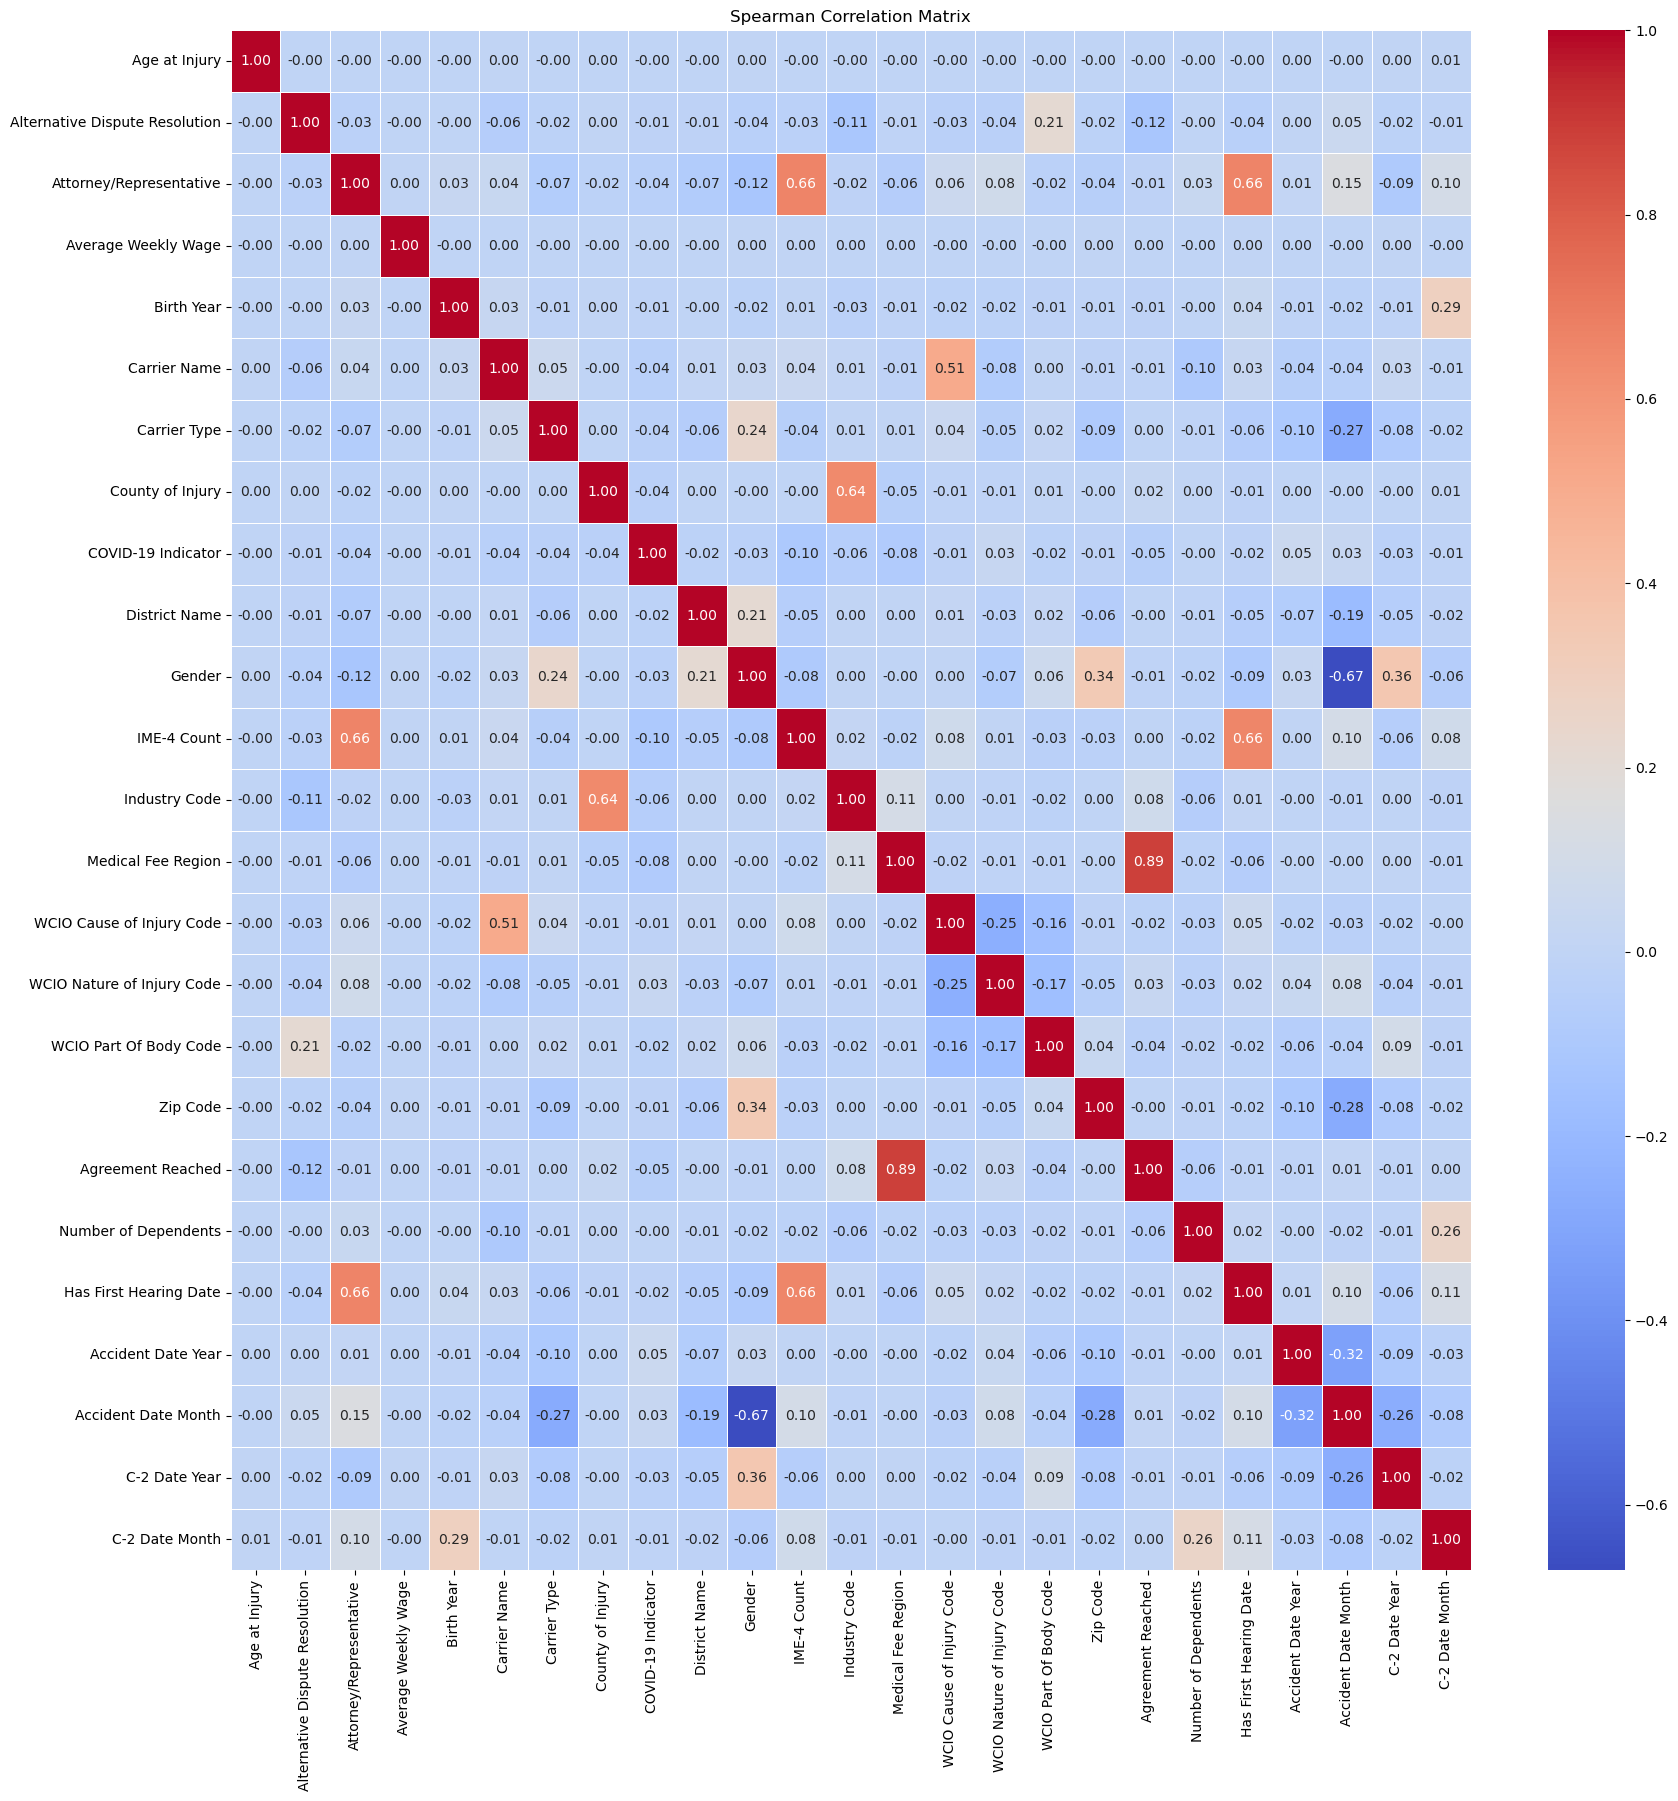

In [21]:

numeric_df = train.select_dtypes(include=['float64', 'int64']).fillna(0)

# correlation matrix
correlation_matrix = numeric_df.corr(method='spearman')

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Spearman Correlation Matrix')
plt.show()


In [22]:
def print_highly_corr_feat(correlation_matrix, threshold=0.8):
    """
    Prints pairs of features that are highly correlated with each other.
    
    Parameters:
    correlation_matrix (pd.DataFrame): The correlation matrix to analyze.
    threshold (float): The correlation threshold above which features are considered highly correlated.
    """
    # Take the absolute value of the correlation matrix
    corr = correlation_matrix.abs()
    
    # Select the upper triangle of the correlation matrix
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    
    # Find pairs of features with correlations above the threshold
    highly_corr_pairs = [(column, row) for column in upper.columns for row in upper.index 
                         if upper.loc[row, column] > threshold]
    
    if highly_corr_pairs:
        print(f'Highly correlated feature pairs (>{threshold}):')
        for col1, col2 in highly_corr_pairs:
            print(f"{col1} - {col2}: {upper.loc[col2, col1]:.2f}")
    else:
        print(f'No feature pairs found with correlation above {threshold}.')

In [23]:
train.shape

(574026, 32)

In [24]:
print_highly_corr_feat(correlation_matrix)

Highly correlated feature pairs (>0.8):
Agreement Reached - Medical Fee Region: 0.89


The features above present a high correlation, now let's check feature selection methods

### RFE

In [28]:
print(train.shape)        # Should be (n_samples, n_features)
print(train_target.shape)

train_target_ravel = train_target.values.ravel()

train_target_ravel.shape

(574026, 32)
(574026, 1)


(574026,)

In [31]:
X_train, X_val, y_train, y_val = train_test_split(train, train_target, test_size=0.2, random_state=1, stratify=train_target)

In [38]:
y_train = y_train.values.ravel()


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [39]:

y_train.shape

(459220,)

In [40]:
#RFE 

#no of features
nof_list=np.arange(1,8)            
high_score=0
#Variable to store the optimum features
nof=0           
train_score_list =[]
val_score_list = []

for n in range(len(nof_list)):
    model = LogisticRegression()
    
    rfe = RFE(estimator = model,n_features_to_select = nof_list[n])
    X_train = rfe.fit_transform(X_train,y_train)
    X_val_rfe = rfe.transform(X_train)
    model.fit(X_train,y_train)
    
    #storing results on training data
    train_score = model.score(X_train,y_train)
    train_score_list.append(train_score)
    
    #storing results on training data
    val_score = model.score(X_val_rfe,y_train)
    val_score_list.append(val_score)
    
    #check best score
    if(val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

ValueError: could not broadcast input array from shape (7,459220) into shape (1,459220)